In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
df_features_market = pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/features_market.parquet"
)
df_presence = pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/sp500_universe.parquet"
)

In [3]:
df_features_market

,date,permno,mkt_log_ret,mkt_cap_rank,mkt_mom_1m,mkt_mom_3m,mkt_volatility,mkt_drawdown,mkt_turnover,mkt_rel_vol,mkt_liq_risk
0,2007-01-03,10078,0.021898,0.751529,0.000000,0.000000,-4.605070,0.0,0.017925,0.69,0.0
1,2007-01-04,10078,0.026716,0.771145,0.000000,0.000000,-4.605070,0.0,0.015225,0.69,0.001754
2,2007-01-05,10078,-0.015943,0.763859,0.000000,0.000000,-4.605070,0.0,0.013224,0.69,0.001783
3,2007-01-08,10078,0.008889,0.768775,0.000000,0.000000,-4.605070,0.0,0.011669,0.69,0.001767
4,2007-01-09,10078,0.01406,0.779533,0.000000,0.000000,-4.605070,0.0,0.014076,0.680853,0.001745
...,...,...,...,...,...,...,...,...,...,...,...
255658,2024-12-24,93436,0.070991,2.74525,0.270950,0.549221,-3.356946,-0.037324,0.01832,0.517379,0.001016
255659,2024-12-26,93436,-0.017787,2.736065,0.293594,0.542388,-3.383256,-0.055111,0.023519,0.623304,0.000132
255660,2024-12-27,93436,-0.050745,2.706619,0.243913,0.467393,-3.370154,-0.105856,0.025336,0.6523,0.00051
255661,2024-12-30,93436,-0.033569,2.692358,0.226257,0.429342,-3.381642,-0.139425,0.019957,0.53752,0.000455


In [7]:
df_lr = df_features_market.pivot(index="date", columns="permno", values="mkt_log_ret")

<Axes: xlabel='date'>

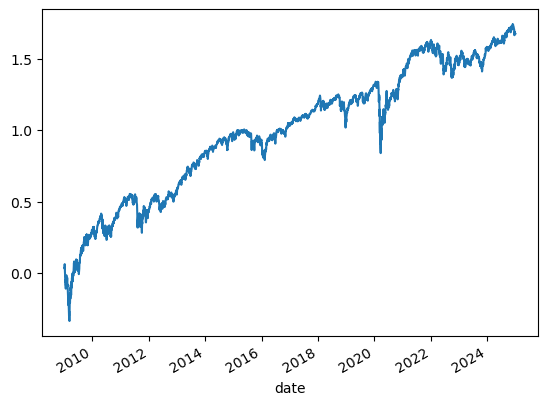

In [12]:
df_lr[df_presence.astype(bool)].mean(1).cumsum().plot()

In [13]:
import wrds

In [14]:
try:
    db_num = wrds.Connection(wrds_username="audricms")
    print("Connection successful via .pgpass!")
except Exception as e:
    print(f"Connection failed: {e}")

Loading library list...
Done
Connection successful via .pgpass!


In [15]:
query = f"""
SELECT *
FROM ff.fivefactors_daily
WHERE date >= '2008-01-01'
"""

df_wrds_factors = db_num.raw_sql(query)

<Axes: xlabel='date'>

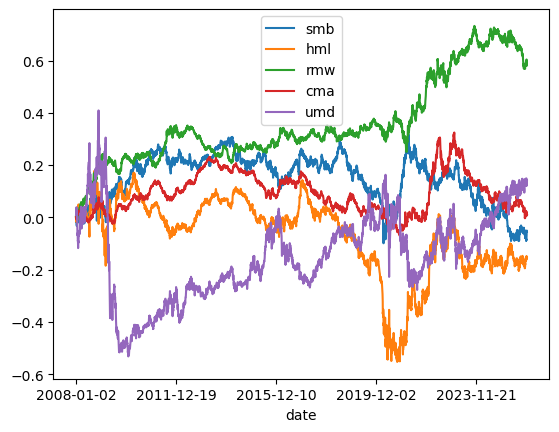

In [20]:
df_wrds_factors.set_index("date").drop(columns=["mktrf", "rf"]).cumsum().plot()

✅ Loaded 4026 days of factor data.
Range: 2009-01-02 to 2024-12-31
Factors: ['MKT', 'SMB', 'HML', 'UMD', 'QMJ', 'BAB']


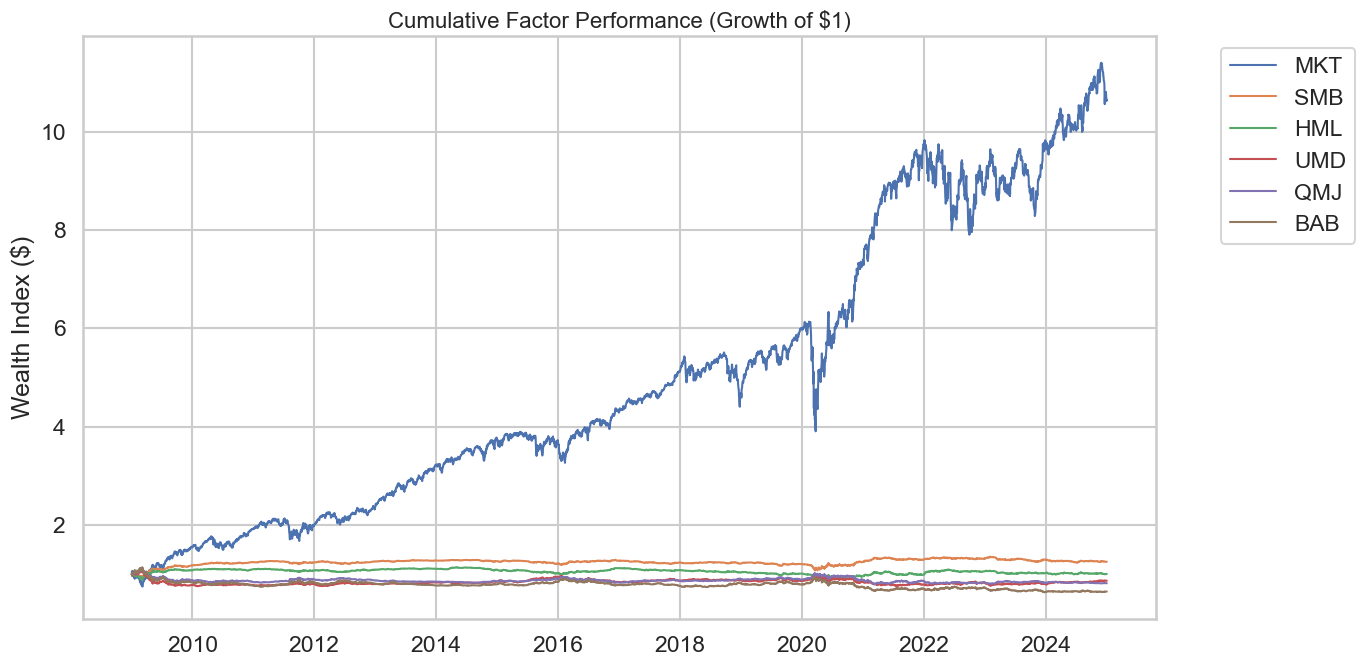

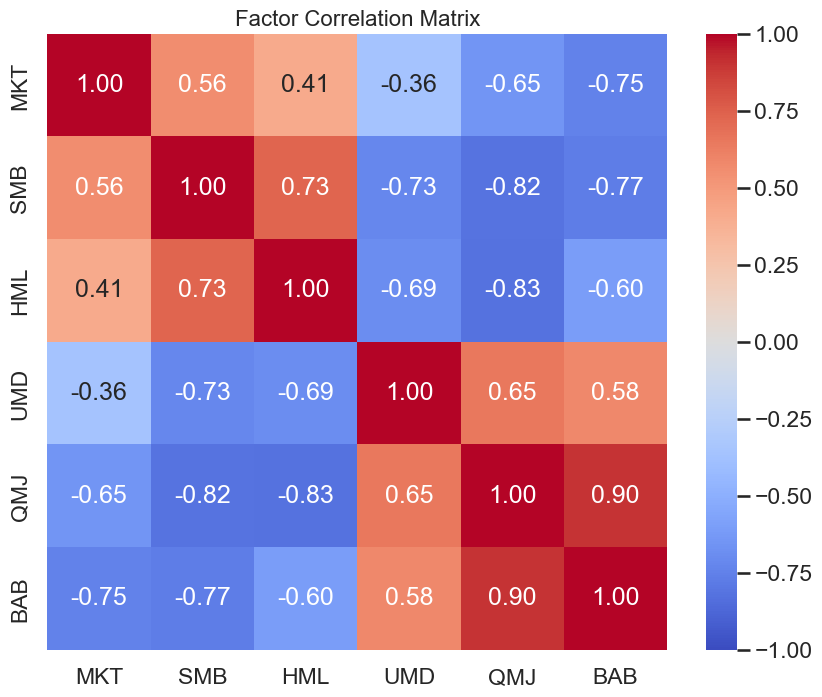


--- Factor Statistics (Annualized) ---


,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown,t-stat,Skewness
MKT,0.1480,0.1959,0.7553,-0.3839,3.0189,-0.2802
SMB,0.0143,0.0494,0.2886,-0.1716,1.1534,0.7981
HML,0.0005,0.0580,0.0083,-0.2185,0.0333,0.4916
UMD,-0.0090,0.0809,-0.1111,-0.3351,-0.4442,-1.1266
QMJ,-0.0127,0.0727,-0.1741,-0.3216,-0.6958,-0.7191
BAB,-0.0272,0.1026,-0.2651,-0.4815,-1.0594,-0.4472



--- Bootstrap Analysis (95% Confidence Intervals) ---


,Sharpe (Lower 5%),Sharpe (Median),Robust?
MKT,0.3738,0.7758,✅
SMB,-0.1500,0.2919,⚠️
HML,-0.4273,0.0272,⚠️
UMD,-0.4847,-0.1031,⚠️
QMJ,-0.5712,-0.2064,⚠️
BAB,-0.6437,-0.2880,⚠️



--- Performance by Decade (Ann. Return) ---


,MKT,SMB,HML,UMD,QMJ,BAB
Decade,,,,,,
2000,43.14%,16.24%,7.53%,-25.12%,-12.61%,-17.41%
2010,13.62%,0.28%,-0.61%,1.02%,0.12%,-0.57%
2020,11.48%,0.75%,-0.14%,0.11%,-1.77%,-4.08%



--- Recent Performance (2020 - Present) ---


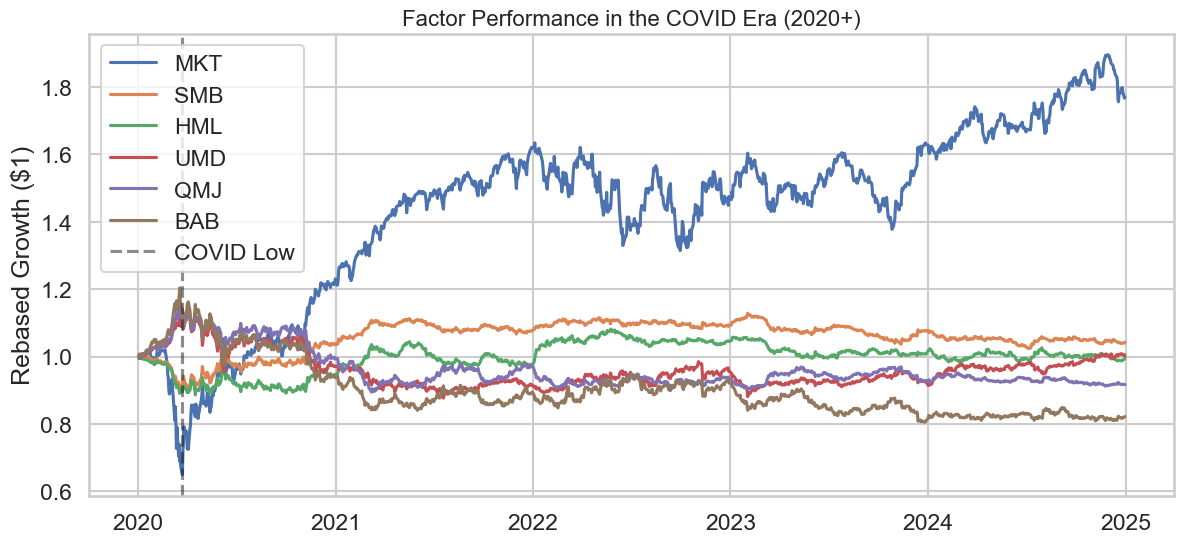

In [32]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust path to import src
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from src.evaluation.performance import compute_metrics
from src.evaluation.robustness import bootstrap_analysis, compute_t_stat

# --- Config ---
# Set plotting style
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = project_root / "data" / "processed" / "factors_returns.parquet"

# 1. Load Data
if not DATA_PATH.exists():
    print(f"❌ File not found: {DATA_PATH}")
else:
    df_factors = pd.read_parquet(DATA_PATH)
    # Ensure index is Datetime
    if "date" in df_factors.columns:
        df_factors = df_factors.set_index("date")

    print(f"✅ Loaded {len(df_factors)} days of factor data.")
    print(f"Range: {df_factors.index.min().date()} to {df_factors.index.max().date()}")
    print(f"Factors: {list(df_factors.columns)}")

# 2. Cumulative Wealth Plot (The "Growth of $1")
# We use Log Returns -> cumsum -> exp to get the wealth index
wealth_index = np.exp(df_factors.cumsum())

plt.figure(figsize=(14, 7))
for col in wealth_index.columns:
    plt.plot(wealth_index.index, wealth_index[col], label=col, linewidth=1.5)

plt.title("Cumulative Factor Performance (Growth of $1)", fontsize=16)
plt.ylabel("Wealth Index ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 3. Correlation Matrix (The "Sanity Check")
# We expect specific relationships:
# - HML vs UMD: Negative (Value vs Momentum usually anti-correlated)
# - BAB vs MKT: Low or Negative (Low Beta is defensive)
# - SMB vs MKT: Positive (Small caps have higher beta)
corr_matrix = df_factors.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Factor Correlation Matrix", fontsize=16)
plt.show()

# 4. Statistical Performance Report
print("\n--- Factor Statistics (Annualized) ---")
stats_list = []

for col in df_factors.columns:
    # Use our robust metrics engine
    m = compute_metrics(df_factors[col], period=252)
    t_stat = compute_t_stat(df_factors[col])

    # Add t-stat to the series
    m["t-stat"] = t_stat
    m.name = col
    stats_list.append(m)

df_stats = pd.DataFrame(stats_list)
# Display key metrics sorted by Sharpe
display_cols = [
    "Annualized Return",
    "Annualized Vol",
    "Sharpe Ratio",
    "Max Drawdown",
    "t-stat",
    "Skewness",
]
display(df_stats[display_cols].sort_values("Sharpe Ratio", ascending=False))

# 5. Robustness: Bootstrap Analysis
# "Is the Sharpe Ratio real, or just luck?"
# We use Block Bootstrap to preserve serial correlation (volatility clustering)
print("\n--- Bootstrap Analysis (95% Confidence Intervals) ---")
robustness_results = {}

for col in df_factors.columns:
    # Run 1000 block bootstraps
    ci = bootstrap_analysis(df_factors[col], n_samples=1000, block_size=22)

    # We care about the 5% lower bound of the Sharpe Ratio
    sharpe_lower = ci.loc["Sharpe Ratio", "5%"]
    sharpe_median = ci.loc["Sharpe Ratio", "50%"]

    robustness_results[col] = {
        "Sharpe (Lower 5%)": sharpe_lower,
        "Sharpe (Median)": sharpe_median,
        "Robust?": "✅" if sharpe_lower > 0 else "⚠️",
    }

df_robust = pd.DataFrame(robustness_results).T
display(df_robust.sort_values("Sharpe (Median)", ascending=False))

# 6. Decade Stability Test
# A good factor should work across different regimes (2000s, 2010s, 2020s)
print("\n--- Performance by Decade (Ann. Return) ---")
df_decade = df_factors.copy()
df_decade["Decade"] = (df_decade.index.year // 10) * 10

decade_perf = df_decade.groupby("Decade").mean() * 252
display(
    decade_perf.style.background_gradient(cmap="RdYlGn", axis=None).format("{:.2%}")
)

# 7. Recent Regime Check (Post-COVID)
# Zoom in on 2020-Present to see behavior during the crash and recovery
print("\n--- Recent Performance (2020 - Present) ---")
recent_df = df_factors[df_factors.index >= "2020-01-01"]

if not recent_df.empty:
    recent_wealth = np.exp(recent_df.cumsum())
    # Rebase to 1.0 at start of period
    recent_wealth = recent_wealth / recent_wealth.iloc[0]

    plt.figure(figsize=(14, 6))
    for col in recent_wealth.columns:
        plt.plot(recent_wealth.index, recent_wealth[col], label=col)

    plt.title("Factor Performance in the COVID Era (2020+)", fontsize=16)
    plt.axvline(
        pd.Timestamp("2020-03-23"),
        color="k",
        linestyle="--",
        alpha=0.5,
        label="COVID Low",
    )
    plt.ylabel("Rebased Growth ($1)")
    plt.legend()
    plt.show()
else:
    print("⚠️ Data ends before 2020.")

In [8]:
import pandas as pd

u = pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/sp500_universe.parquet"
)

In [9]:
u.stack()

date        permno
2009-01-02  10078     1.0
            10104     1.0
            10107     1.0
            10108     0.0
            10137     1.0
                     ... 
2024-12-31  93159     0.0
            93246     1.0
            93422     0.0
            93429     1.0
            93436     1.0
Length: 4303794, dtype: float64

In [3]:
pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/features_macro.parquet"
)

,date,macro_unemp_rate,macro_unemp_delta,macro_cpi_yoy,macro_ppi_yoy,macro_yield_curve,macro_risk_free,macro_vix
0,2007-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,0.045,0.001,0.019717,0.009169,-0.0009,0.0467,2.568022
2,2007-01-05,0.045,0.001,0.019717,0.009169,-0.0009,0.0462,2.526528
3,2007-01-08,0.045,0.001,0.019717,0.009169,-0.0011,0.0465,2.575661
4,2007-01-09,0.045,0.001,0.019717,0.009169,-0.0012,0.0466,2.564949
...,...,...,...,...,...,...,...,...
4525,2024-12-24,0.042,0.001,0.027683,-0.001596,0.0029,0.0459,2.878074
4526,2024-12-26,0.042,0.001,0.027683,-0.001596,0.0030,0.0459,2.725890
4527,2024-12-27,0.042,0.001,0.027683,-0.001596,0.0028,0.0458,2.755570
4528,2024-12-30,0.042,0.001,0.027683,-0.001596,0.0031,0.0462,2.830268


In [4]:
pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/features_market.parquet"
)

,date,permno,mkt_log_ret,mkt_cap_rank,mkt_mom_1m,mkt_mom_3m,mkt_volatility,mkt_drawdown,mkt_turnover,mkt_rel_vol,mkt_liq_risk
0,2007-01-03,10078,0.021898,0.751529,0.000000,0.000000,-4.605070,0.000000,0.017925,0.690000,0.000000
1,2007-01-04,10078,0.026716,0.771145,0.000000,0.000000,-4.605070,0.000000,0.015225,0.690000,0.001754
2,2007-01-05,10078,-0.015943,0.763859,0.000000,0.000000,-4.605070,0.000000,0.013224,0.690000,0.001783
3,2007-01-08,10078,0.008889,0.768775,0.000000,0.000000,-4.605070,0.000000,0.011669,0.690000,0.001767
4,2007-01-09,10078,0.014060,0.779533,0.000000,0.000000,-4.605070,0.000000,0.014076,0.680853,0.001745
...,...,...,...,...,...,...,...,...,...,...,...
255658,2024-12-24,93436,0.070991,2.745250,0.270950,0.549221,-3.356946,-0.037324,0.018320,0.517379,0.001016
255659,2024-12-26,93436,-0.017787,2.736065,0.293594,0.542388,-3.383256,-0.055111,0.023519,0.623304,0.000132
255660,2024-12-27,93436,-0.050745,2.706619,0.243913,0.467393,-3.370154,-0.105856,0.025336,0.652300,0.000510
255661,2024-12-30,93436,-0.033569,2.692358,0.226257,0.429342,-3.381642,-0.139425,0.019957,0.537520,0.000455


In [5]:
pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/features_ratios.parquet"
)

,date,permno,ratio_pb,ratio_ey,ratio_roe,ratio_de,ratio_div_yield
0,2007-01-03,10078,0.000000,0.500000,0.000000,0.000000,0.000000
1,2007-01-03,81776,0.000000,0.500000,0.000000,0.000000,0.000000
2,2007-01-03,81857,0.000000,0.500000,0.000000,0.000000,0.000000
3,2007-01-03,82196,0.000000,0.500000,0.000000,0.000000,0.000000
4,2007-01-03,82276,0.000000,0.500000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
3255658,2024-12-31,79545,0.742554,0.127084,0.151945,0.868297,0.013841
3255659,2024-12-31,52230,1.781060,0.038887,0.184571,0.667861,0.030088
3255660,2024-12-31,90319,1.512745,0.039831,0.329729,0.330901,0.004226
3255661,2024-12-31,13447,3.198979,0.006065,0.168991,0.753473,0.010792


In [6]:
pd.read_parquet(
    "/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/data/processed/linked_embeddings.parquet"
)

,effective_date,stock_symbol,n_news,sent_score_sum,sent_abs_sum,sent_pos_sum,sent_neg_sum,sent_score_mean,sent_abs_mean,emb_mean,emb_mean_wabs,emb_mean_pos,emb_mean_neg,date,permno,comnam
0,2009-02-17,NAV,1,0.896717,0.896717,0.924509,0.027792,0.896717,0.896717,"[0.56591797, 0.31420898, 0.32788086, -0.189697...","[0.56591797, 0.31420898, 0.32788086, -0.189697...","[0.56591797, 0.31420898, 0.32788086, -0.189697...","[0.56591797, 0.31420898, 0.32788086, -0.189697...",2009-02-17,12503,NAVISTAR INTERNATIONAL CORP
1,2009-04-13,WOR,1,0.840662,0.840662,0.909153,0.068491,0.840662,0.840662,"[0.77246094, -0.14782715, -0.065979004, 0.0528...","[0.77246094, -0.14782715, -0.065979004, 0.0528...","[0.77246094, -0.14782715, -0.065979004, 0.0528...","[0.77246094, -0.14782715, -0.065979004, 0.0528...",2009-04-13,83601,WORTHINGTON INDUSTRIES INC
2,2009-04-30,A,1,0.640473,0.640473,0.797031,0.156558,0.640473,0.640473,"[0.2142334, 0.105651855, -0.24902344, -0.29345...","[0.21423341, 0.10565186, -0.24902344, -0.29345...","[0.21423338, 0.105651855, -0.24902344, -0.2934...","[0.2142334, 0.10565186, -0.24902344, -0.293457...",2009-04-30,87432,AGILENT TECHNOLOGIES INC
3,2009-05-26,AM,1,0.895927,0.895927,0.930875,0.034948,0.895927,0.895927,"[0.18981934, -0.13342285, -0.24157715, -0.5356...","[0.18981934, -0.13342285, -0.24157715, -0.5356...","[0.18981934, -0.13342285, -0.24157715, -0.5356...","[0.18981934, -0.13342285, -0.24157715, -0.5356...",2009-05-26,13056,AMERICAN GREETINGS CORP
4,2009-06-02,A,1,0.182774,0.182774,0.569713,0.386940,0.182774,0.182774,"[0.3154297, -0.19836426, 0.49780273, 0.1358642...","[0.3154297, -0.19836426, 0.49780273, 0.1358642...","[0.3154297, -0.19836426, 0.49780273, 0.1358642...","[0.3154297, -0.19836426, 0.4978027, 0.13586426...",2009-06-02,87432,AGILENT TECHNOLOGIES INC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563432,2024-01-04,AMD,8,6.461851,6.461851,7.108971,0.647119,0.807731,0.807731,"[0.17779016, 0.024653435, 0.07427549, -0.10299...","[0.18352199, 0.024399245, 0.091175586, -0.0918...","[0.18019511, 0.025031695, 0.080573484, -0.0976...","[0.14697438, 0.031347208, -0.025294272, -0.155...",2024-01-04,61241,ADVANCED MICRO DEVICES INC
563433,2024-01-05,AMD,14,3.161322,8.067260,7.007829,3.846507,0.225809,0.576233,"[0.034093447, -0.039108276, 0.27708218, -0.029...","[0.07360618, 0.03750978, 0.27058375, -0.024162...","[0.008362489, 0.12083384, 0.17991616, -0.06806...","[0.13750927, -0.16450521, 0.42248002, 0.052075...",2024-01-05,61241,ADVANCED MICRO DEVICES INC
563434,2024-01-08,AMD,12,6.619107,9.204071,9.113649,2.494542,0.551592,0.767006,"[0.08722941, 0.06332048, 0.09486898, -0.022652...","[0.07363922, 0.07012826, 0.05662064, -0.052507...","[0.08755392, 0.084484786, 0.019894075, -0.0626...","[0.088072225, -0.014667085, 0.36502773, 0.1214...",2024-01-08,61241,ADVANCED MICRO DEVICES INC
563435,2024-01-09,AMD,12,4.198352,5.945890,6.230275,2.031923,0.349863,0.495491,"[0.055138905, 0.1093572, 0.15657552, 0.0729675...","[0.07398387, 0.2134113, 0.039264165, 0.0242382...","[0.08139806, 0.23479164, 9.3355964e-05, 0.0021...","[0.17800455, 0.028082034, 0.30450833, 0.151827...",2024-01-09,61241,ADVANCED MICRO DEVICES INC
